In [3]:
import numpy as np
from matplotlib import pyplot as plt
import healpy as hp

%matplotlib inline  
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [10, 6]

See https://github.com/healpy/healpy/blob/main/doc/tutorial.ipynb first.

As described there, healpy maps are just numpy arrays, of a particular size and ordering.  We'll always use the "ring" ordering, which is the default.  

# A simple map
To see how this runs, let's make a very coarse map where the value of the pixel (and thus the color) is just its index in the numpy array, and then a smaller-pixel map to see how the rings go from top to bottom.


Approximate resolution at NSIDE 512 is 0.11 deg


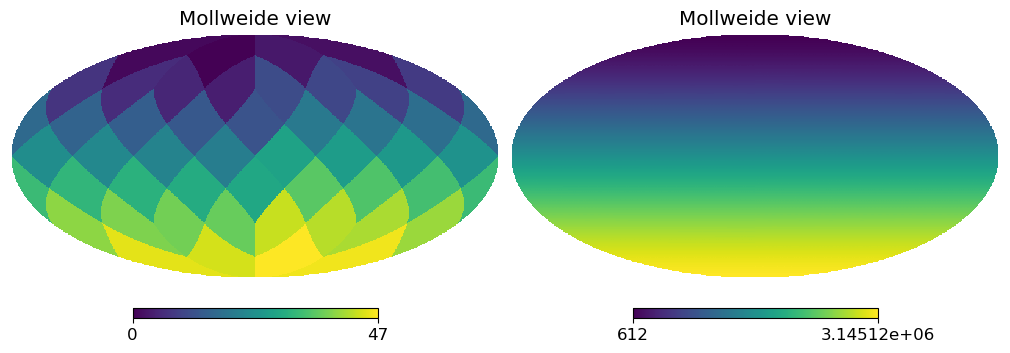

In [94]:
plt.clf()

# large pixels
NSIDE = 2
npix = hp.nside2npix(NSIDE)
m = np.arange(npix*1.0)
hp.mollview(m,sub=(1,2,1))    # notice the use of the "sub" argument to put the map in a subplot position

# smaller pixels, so it's easier to see the "top down" gradient"
NSIDE=512
npix = hp.nside2npix(NSIDE)
m = np.arange(npix)
hp.mollview(m,sub=(1,2,2))

print(f"Approximate resolution at NSIDE {NSIDE} is {hp.nside2resol(NSIDE, arcmin=True) / 60:.2f} deg")

# Making and using a mask

Often we don't want a full-sky map; we want a smaller one, as observed by an instrument or masking out high-foreground areas.

Here the mask will be 1 inside the area that we want to keep, and 0 or NaN outside that area.  The healpy routines (for calculating things, and for plotting) usually work well with NaN's outside the desired area, but sometimes we may want zeros there instead.

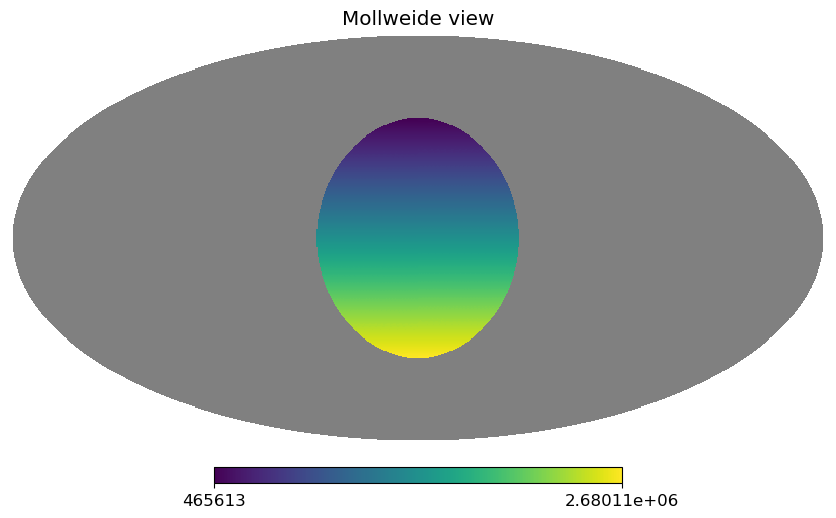

In [95]:
# pixel indices inside a circular disk with center = (lat,lon) and radius = rdisk
lat = np.pi/2 # 0 (north pole) to pi (south pole)
lon = 0 # 0 to 2pi
rdisk_deg = 45  #degrees
center = hp.ang2vec(lat,lon)

ipix_disc = hp.query_disc(nside=NSIDE, vec=center, radius=np.radians(rdisk_deg))

# make a mask with ones in the areas we want to keep
mask_ones = np.empty(npix)
mask_ones[:] = 0
mask_ones[ipix_disc] = 1

# Here we set the values inside the mask to the map value, and outside that to a special constant "UNSEEN" 
# that is understood by hp.anafast, below.
map_masked = np.where(mask_ones==1,m,hp.UNSEEN)

#map_masked.mask = mask_ones

hp.mollview(map_masked)

# Make a random "noise" map and calculate its angular power spectrum

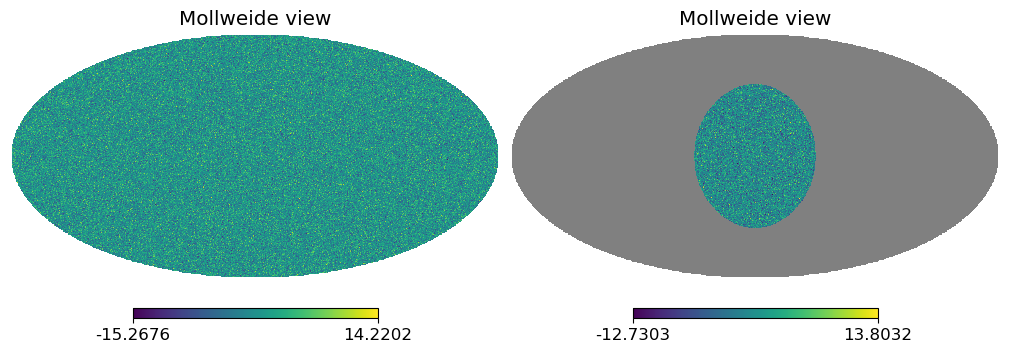

In [96]:
rng = np.random.default_rng()

rms = 10.0
noisemap = rng.normal(size=npix,loc=0.0,scale=np.sqrt(rms))
noisemap_masked = np.where(mask_ones==1,noisemap,hp.UNSEEN)

hp.mollview(noisemap,sub=(1,2,1))
hp.mollview(noisemap_masked,sub=(1,2,2))

# Calculate the C_ell's and D_ells on the masked portion of the map.

Text(0.5, 0, 'ell')

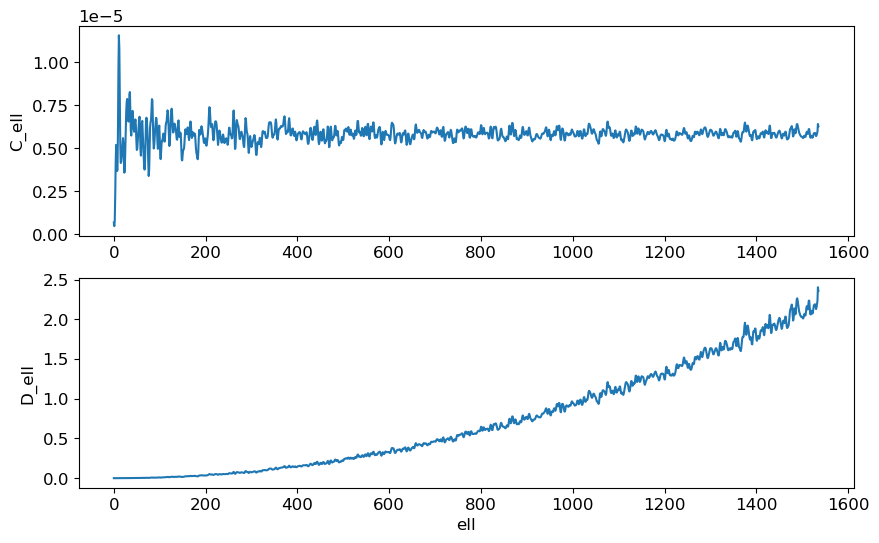

In [97]:

C_ell = hp.anafast(noisemap_masked)
ell = np.arange(len(C_ell))
D_ell = ell*(ell+1)*C_ell/(2*np.pi)

plt.subplot(2,1,1)
plt.plot(ell, C_ell)
plt.ylabel('C_ell')

plt.subplot(2,1,2)
plt.plot(ell,D_ell)
plt.ylabel('D_ell')
plt.xlabel('ell')



# Repeat with a "lat lon" mask

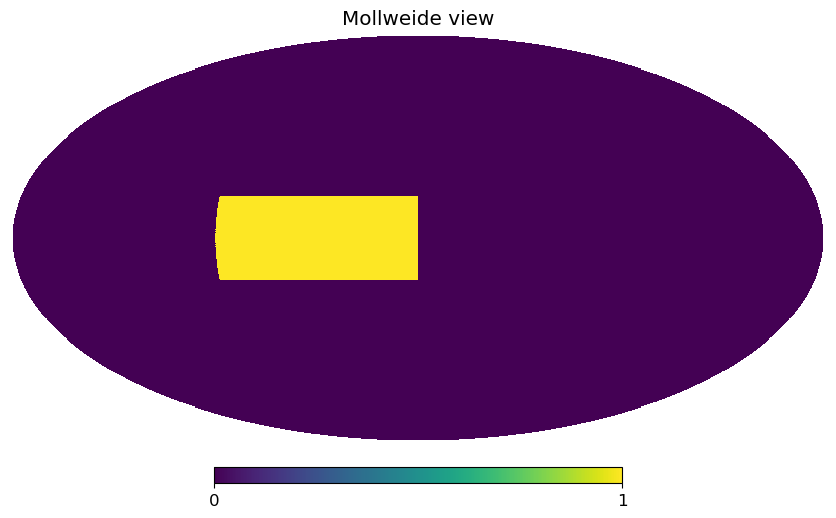

In [129]:
# pixel indices inside a circular disk with center = (lat,lon) and radius = rdisk
lats = (-15, 15) # 
lons = (0, 90)  #  Careful, this won't work if we wrap through zero.

pixlon,pixlat = hp.pixelfunc.pix2ang(NSIDE, np.arange(npix), lonlat=True)

sqmask = np.where( ( (pixlon<lons[1]) & (pixlon>lons[0]) ) & ( (pixlat<lats[1]) & (pixlat>lats[0]) ), 1, 0)

hp.mollview(sqmask)

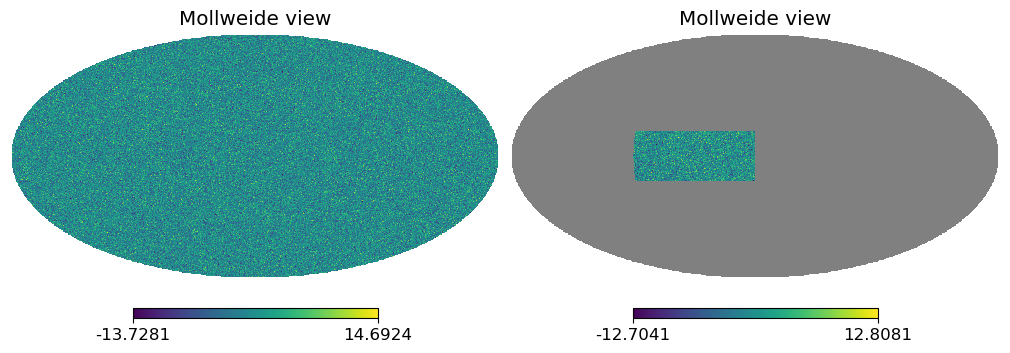

In [132]:
rng = np.random.default_rng()
rms = 10.0
noisemap2 = rng.normal(size=npix,loc=0.0,scale=np.sqrt(rms))
noisemap2_masked = np.where(sqmask==1,noisemap,hp.UNSEEN)

hp.mollview(noisemap2,sub=(1,2,1))
hp.mollview(noisemap2_masked,sub=(1,2,2))

Text(0.5, 0, 'ell')

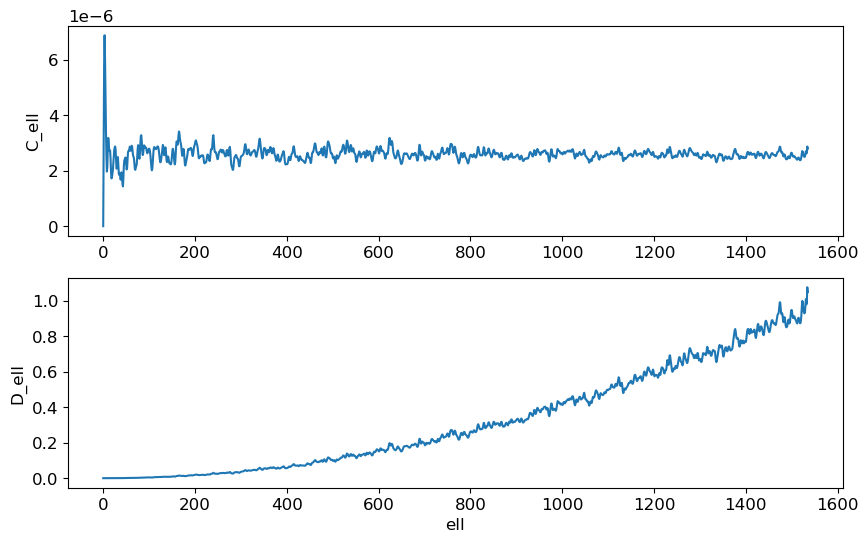

In [133]:
C_ell = hp.anafast(noisemap2_masked)
ell = np.arange(len(C_ell))
D_ell = ell*(ell+1)*C_ell/(2*np.pi)

plt.subplot(2,1,1)
plt.plot(ell, C_ell)
plt.ylabel('C_ell')

plt.subplot(2,1,2)
plt.plot(ell,D_ell)
plt.ylabel('D_ell')
plt.xlabel('ell')